In [1]:
from __future__ import absolute_import, division
import os
import urllib
from io import BytesIO     # for handling byte strings
from io import StringIO    # for handling unicode strings
import pymongo as pm
import math
from numpy.linalg import norm
import numpy as np
import scipy.stats as stats
from scipy.spatial import distance
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.metrics import *
import pandas as pd
import json
import re
from joblib import dump, load
from PIL import Image
import base64
import sys
import matplotlib
import matplotlib.patches as mpatches
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.cm as cm
import matplotlib.lines as mlines
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
from sklearn import linear_model, datasets, neighbors, svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from IPython.display import clear_output
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")


/Users/alles/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/Users/alles/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))
feature_dir = os.path.abspath(os.path.join(proj_dir,'features'))
svg_dir = os.path.abspath(os.path.join(sketch_dir,'svg'))
png_dir = os.path.abspath(os.path.join(sketch_dir,'png'))
datastructures_dir = os.path.join(analysis_dir,'datastructures')

## feature dirs
#example_dir = os.path.abspath(os.path.join(feature_dir,'example'))

## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

if not os.path.exists(datastructures_dir):
    os.makedirs(datastructures_dir)       



In [3]:

# Get only the features from one layer of the NN, FC6
FEAT = np.load(os.path.join(feature_dir, "FEATURES_FC6_sketch_channel-norm.npy"))
num_feats = np.shape(FEAT)[1] # the first dimension is number of sketches, second is number of features     
FEAT = pd.DataFrame(FEAT)
feat_cols = [str(i) for i in np.arange(num_feats)]
FEAT.columns = feat_cols
# FEAT.columns = FEAT.columns.astype(int)

META = pd.read_csv(os.path.join(feature_dir,'METADATA_sketch.csv'))
assert META.shape[0]==FEAT.shape[0]
META['game_id'] = META.sketch_id.str.split('_').str[0]
META['animal'] = META.sketch_id.str.split('_').str[1]
META['cardinality'] = META.sketch_id.str.split('_').str[2]
META['trial_num'] = META.sketch_id.str.split('_').str[3]
META['condition'] = META.sketch_id.str.split('_').str[4]
META.drop(columns=['feature_ind'],inplace=True)

D = pd.concat([META,FEAT],axis=1)
D = D.astype({'trial_num': 'float'})
D['block'] = np.ceil(D['trial_num']/8)
D = D.astype({'block': 'float'})

print("Done!")


Done!


In [4]:
def get_splits(df, 
               folds=5, 
               random_seed=132,
               replace=False,
               group='animal', # or 'cardinality'; might want to create an e.g. 'rabbit_4'; can just 
               identifier='sketch_id'):
    
    num_obs_per_group = int(df.groupby(group).size().mean())
    size = int(num_obs_per_group / folds)## how many obs do include in each split    
    replace = False  # without replacement
    ## create splits
    splits = []
    counter = 0
    while counter < folds:
        fn = lambda obj: obj.loc[np.random.RandomState(random_seed).choice(obj.index, size, replace),:]    
        current_split = df.groupby(group, as_index=False).apply(fn)
        used_ids = current_split.sketch_id.unique()
        
        df = df[~df.sketch_id.isin(used_ids)]
        
        ## sanity check, there is no overlap in image_id
        assert len(np.intersect1d(current_split[identifier],df[identifier]))==0
        splits.append(current_split.reset_index(drop=True))
        counter += 1
        
    splits[-1] = splits[-1].append(df)
    
    return splits


In [5]:
def clf_scoring(clfCond,gameCond):
    DF = D[D['condition'] == gameCond] # number or shape
    splits = get_splits(DF,group=clfCond) # cardinality or animal
    
    acc = []
    clf_score_name = 'clfScore_' + clfCond
    merging_df = pd.DataFrame(columns = ['sketch_id',clf_score_name])
    
    for ind,df in enumerate(splits):
        training_dfs = splits[:ind] + splits[ind+1:]
        trainset = pd.concat(training_dfs)
        testset = df

        Xtrain, Xtest = np.array(trainset[feat_cols]), np.array(testset[feat_cols])
        ytrain, ytest = trainset[clfCond].values, testset[clfCond].values
        
        clf = linear_model.LogisticRegression(penalty='l2',
                                          C=1e-3,
                                          random_state=0,
                                          solver='lbfgs',
                                          multi_class='multinomial',
                                          max_iter=1500)
        clf.fit(Xtrain,ytrain)
        score = clf.score(Xtest, ytest)
        acc.append(score)
        predictions = clf.predict(Xtest)
        split_confmat = confusion_matrix(ytest, predictions)
        
        
        df[clf_score_name] = predictions
        addendum_for_merging = df[['sketch_id',clf_score_name]]
        merging_df = merging_df.append(addendum_for_merging)
        
        
        confmat = split_confmat if ind == 0 else split_confmat + confmat
    
#     DF = DF.merge(merging_df,on='sketch_id')
#     print(len(DF[clf_score_name]))
    return [acc,confmat,merging_df]

# A=animal,C=cardinality ; S=shape,N=number
ASacc,ASconf,ASdf = clf_scoring('animal','shape')
ANacc,ANconf,ANdf = clf_scoring('animal','number')
CSacc,CSconf,CSdf = clf_scoring('cardinality','shape')
CNacc,CNconf,CNdf = clf_scoring('cardinality','number')

# put together the full dataframe
mergeDFanimal = ASdf.append(ANdf)
mergeDFcardinality = CSdf.append(CNdf)
D = D.merge(mergeDFanimal,on="sketch_id")
D = D.merge(mergeDFcardinality,on="sketch_id")
# now save it out!
# np.save(os.path.join(datastructures_dir,"clfD.npy"), D)

saveD = D.copy()
saveD.drop(D.columns[6:4102], axis=1, inplace=True) # these just happen to be the feature columns, which we don't need
saveD.to_csv(os.path.join(datastructures_dir,"clfD.csv"))

# save out the confmats to the directory so we can import them into our recog analysis
np.save(os.path.join(datastructures_dir,"AA_CLFconfmat.npy"), ASconf)
np.save(os.path.join(datastructures_dir,"CA_CLFconfmat.npy"), ANconf) #number production, animal recog
np.save(os.path.join(datastructures_dir,"AC_CLFconfmat.npy"), CSconf) #shape production, cardinality recog
np.save(os.path.join(datastructures_dir,"CC_CLFconfmat.npy"), CNconf)

np.save(os.path.join(datastructures_dir,"AA_CLFacc.npy"), ASacc)
np.save(os.path.join(datastructures_dir,"CA_CLFacc.npy"), ANacc) #number production, animal recog
np.save(os.path.join(datastructures_dir,"AC_CLFacc.npy"), CSacc) #shape production, cardinality recog
np.save(os.path.join(datastructures_dir,"CC_CLFacc.npy"), CNacc)




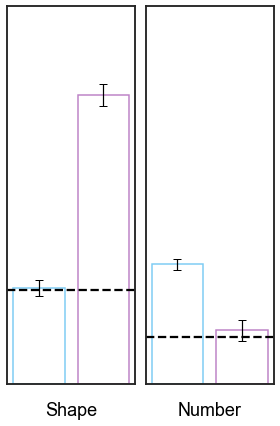

In [11]:
def cf95(arr, z=1.96):
    mean = np.mean(arr)
    std = np.std(arr)
    answer = z * std / np.sqrt(np.size(arr))
    return answer

fig , (ax1,ax2) = plt.subplots(1,2 , sharey=True, figsize = (4,6))

ax1.set_ylim(0,1)

# fig.suptitle("Model",fontsize=24)

# this subplot is for predicting shape
ax1.bar(["CA","AA"],
        [np.mean(ANacc), # predicting animals based on numbers
         np.mean(ASacc)], # predicting animals based on animals
        color = ['#7DCCF4','#BD83C7'], #['#6a6e9c','#b53819'],
        yerr = [cf95(ANacc),
                cf95(ASacc)], error_kw={'linewidth':1.2,'capsize':4})

# this subplot is for predicting number
ax2.bar(["CC","AC"],
        [np.mean(CNacc),
         np.mean(CSacc)],
        color = ['#7DCCF4','#BD83C7'], #['#6a6e9c','#b53819'],
        yerr = [cf95(CNacc),
                cf95(CSacc)], error_kw={'linewidth':1.2,'capsize':4})

l1=ax1.axhline(0.25,color='black',ls='--')
l1.set_label('l1')

l2=ax2.axhline(0.125,color='black',ls='--')
l2.set_label('l2')

ax1.set_xlabel("Shape",color='k') #A04EAE #b53819
ax1.set_xticklabels([])
ax1.set_yticks([])

# ax1.set_yticks([0,.25,.5,.75,1])
# ax1.set_yticklabels(['0','.25','.5','.75','1'])
# ax1.set_ylabel("Accuracy")
ax2.set_xlabel("Number",color='k') #6369AF #6a6e9c
ax2.set_xticklabels([])

# ax1.set_facecolor('#f9d9ff')
# ax2.set_facecolor('#bfcbff')

ax1.get_children()[1].set_color((0,0,0,0))
ax1.get_children()[2].set_color((0,0,0,0))
ax1.get_children()[1].set_edgecolor('#7DCCF4')
ax1.get_children()[2].set_edgecolor('#BD83C7')
ax2.get_children()[1].set_color((0,0,0,0))
ax2.get_children()[2].set_color((0,0,0,0))
ax2.get_children()[1].set_edgecolor('#7DCCF4')
ax2.get_children()[2].set_edgecolor('#BD83C7')


# fig.text(0.5, 0, 'Predicting', ha='center', fontsize=18)
# fig.tight_layout()
fig.subplots_adjust(left=.2, right=.8,top=.9,bottom=0.2)
plt.tight_layout()
fig.subplots_adjust(bottom=0.1)

fig.savefig('../results/plots/accModel.pdf')



In [7]:
print("Congruent classifications:")
print("Cardinality games, number ratings mean: ",np.round(np.mean(CNacc),3), 
      "\n upper 95CI:", np.round(np.mean(CNacc) + cf95(CNacc),3),
      "\n lower 95CI: ",np.round(np.mean(CNacc) - cf95(CNacc),3))
print("Animal games, shape ratings mean: ",np.round(np.mean(ASacc),3), 
      "\n upper 95CI:", np.round(np.mean(ASacc) + cf95(ASacc),3),
      "\n lower 95CI: ",np.round(np.mean(ASacc) - cf95(ASacc),3),'\n\n')

print("Incongruent:")
print("Animal games, number ratings mean: ",np.round(np.mean(ANacc),3), 
      "\n upper 95CI:", np.round(np.mean(ANacc) + cf95(ANacc),3),
      "\n lower 95CI: ",np.round(np.mean(ANacc) - cf95(ANacc),3))
print("Cardinality games, shape ratings mean: ",np.round(np.mean(CSacc),3), 
      "\n upper 95CI:", np.round(np.mean(CSacc) + cf95(CSacc),3),
      "\n lower 95CI: ",np.round(np.mean(CSacc) - cf95(CSacc),3))

Congruent classifications:
Cardinality games, number ratings mean:  0.317 
 upper 95CI: 0.332 
 lower 95CI:  0.303
Animal games, shape ratings mean:  0.765 
 upper 95CI: 0.794 
 lower 95CI:  0.736 


Incongruent:
Animal games, number ratings mean:  0.255 
 upper 95CI: 0.277 
 lower 95CI:  0.233
Cardinality games, shape ratings mean:  0.143 
 upper 95CI: 0.171 
 lower 95CI:  0.116
